# TI3145TU Midterm Assignment 
## Football Players Wages

We hope you enjoy this assignment, good luck!

Student names: Edlyn Santha Kumaran, Yan Tavares

Student numbers: 5730937, 5559790

### <font color="orange"> **Overall Methodology** </font>

For this assigment we keep only 20% of the data from "football_wages.csv" to be used as "unseen_data", the remaining 80% will be used as training and validation, this subset is called "seen_data". Since the dataset is not too big and the models can be trained quickly, we will make use of cross validation to minimize overfitting. Every model will be trained and tunned respectively in a random 80%/20% split of the "seen_data".

There will be three types of tests, "models_data_test" that will predict the values within "models_data", "unseen_data_test" that predicts "unseen_data", and "autograder_test" data predicts the autograder values in "football_autograder.csv".

Predictions will be done using KNN and SGD, the only difference in the proceedure is the hyperparameters tuning.

### <font color="orange">  **Imports, Data Loading and Preprocessing** </font>

Data is read from the csv file 'football_wages.csv'.

To convert the nationaility_name column from strings to numeric data, each nationality is assigned an integer, based on its ranking of average log_wages. The X dataset is standardized, but Y is not. The reason for not standardizing Y is that the values are already small and after some tests it was proven that removing the logarithm scale followed by standardization led to worse performance than leaving it as it is.

In [29]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [30]:
data = pd.read_csv('football_wages.csv')
data_autograder = pd.read_csv('football_autograder.csv')

data.head()

,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,log_wages
0,27.0,183.0,76.0,b'Korea Republic',57.0,58.0,54.0,30.0,55.0,53.0,...,60.0,67.0,63.0,58.0,9.0,13.0,8.0,11.0,10.0,3.000000
1,21.0,182.0,70.0,b'France',61.0,72.0,58.0,63.0,46.0,62.0,...,47.0,65.0,31.0,33.0,9.0,11.0,9.0,12.0,11.0,3.000000
2,35.0,182.0,75.0,b'Korea Republic',68.0,68.0,62.0,68.0,68.0,70.0,...,61.0,69.0,36.0,40.0,8.0,12.0,7.0,12.0,6.0,3.301030
3,29.0,169.0,70.0,b'Paraguay',67.0,67.0,62.0,55.0,50.0,71.0,...,59.0,84.0,40.0,55.0,6.0,10.0,11.0,15.0,9.0,2.698970
4,30.0,176.0,74.0,b'Austria',65.0,65.0,63.0,49.0,53.0,63.0,...,58.0,75.0,65.0,64.0,12.0,15.0,10.0,8.0,10.0,3.477121


In [31]:
########### Pipeline Configuration ##############
Random_num_nationalities = True
Rank_nationalities = False
drop_nationalities = False
scale_data = True
Apply_PCA_transform = True

#Pipeline 1 --> True,False,False,True,True
#Pipeline 2 --> True,False,False,True,True
#Pipeline 3 --> False,True,False,True,False

#################################################


if Random_num_nationalities:
    # sort the data in ascending order of average log_wages by nationality
    # Assign random numbers within the number of nationalities
    
    unique_nationalities = data['nationality_name'].unique()
    num_nationalities = len(unique_nationalities)
    random_numbers = np.random.randint(0, num_nationalities, size=len(data))
    data['nationality_name'] = random_numbers

    unique_nationalities = data_autograder['nationality_name'].unique()
    num_nationalities = len(unique_nationalities)
    random_numbers = np.random.randint(0, num_nationalities, size=len(data_autograder))
    data_autograder['nationality_name'] = random_numbers

    X = data.iloc[:, :-1]
    X_autograder = data_autograder
    Y = data.iloc[:, -1]

if Rank_nationalities: # Limited to only work with the training data
    # sort the data in ascending order of average log_wages by nationality
    mean_by_nationality = data.groupby('nationality_name')['log_wages'].mean().reset_index()
    mean_by_nationality_sorted = mean_by_nationality.sort_values(by='log_wages', ascending=False)
    sorted_data = pd.merge(data, mean_by_nationality_sorted, on='nationality_name', suffixes=('', '_mean'))
    sorted_data = sorted_data.sort_values(by='log_wages_mean', ascending=False).drop(columns='log_wages_mean')
    
    # convert the nationality strings to integers, with 0 being the country with lowest average log_wages
    sorted_data['nationality_name'], uniques = pd.factorize(data['nationality_name'])

    X = sorted_data.iloc[:, :-1]
    Y = sorted_data.iloc[:, -1]
    
    X_autograder =  np.zeros(X.shape) #Autograder will not be able to rank the nationalities since it does not have the mean log_w
    #                                  Therefore data of the autograder will  be set to zero 

if drop_nationalities:

    data.drop('nationality_name',axis=1,inplace=True)
    data_autograder.drop('nationality_name',axis=1,inplace=True)

    X = data.iloc[:, :-1]
    X_autograder = data_autograder
    Y = data.iloc[:, -1]

if scale_data:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_autograder_scaled = scaler.transform(X_autograder)

if Apply_PCA_transform == True:

    explained_variance_threshold = 0.95

    for n_components in range(1, X_scaled.shape[1] + 1):  # Loop from 1 to max number of features
        pca = PCA(n_components=n_components)
        pca.fit(X_scaled)

        # Calculate the cumulative explained variance
        cumulative_variance = np.sum(pca.explained_variance_ratio_)

        # Break the loop when the explained variance threshold is reached
        if cumulative_variance >= explained_variance_threshold:
            print(f'Optimum n_components: {n_components}')
            break

    X_scaled = pca.fit_transform(X_scaled)
    X_autograder_scaled = pca.transform(X_autograder_scaled)


In [33]:

x_seen,x_unseen,y_seen, y_unseen = train_test_split(X_scaled, Y, test_size=0.2, random_state=100)

### <font color="orange">  **Define ftraining & tunning functions** </font>

In [34]:
def train_and_test_knn(k, x_train, y_train, x_val,y_val):
    # Initialize the KNN regressor
    model = KNeighborsRegressor(n_neighbors=k)

    # Train the KNN regressor
    model.fit(x_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(x_val)

    # Calculate error
    error = np.mean(np.abs(y_val - y_pred))

    return model,error

def tune_and_store_knn(x_train,y_train,x_val,y_val):
    min_error = np.inf
    for k in range(1,40):
        model,error = train_and_test_knn(k,x_train,y_train,x_val,y_val)

        if error < min_error:
            min_error = error
            best_k = k
            best_model = model
    print("Best K:", best_k)
    return best_k,best_model,min_error

def train_and_tune_SGD(x_train,y_train,x_val,y_val):

    # Define the parameter grid for alpha (regularization strength) and learning rate
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1],  # Tuning regularization strength
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Different learning rate strategies
        'eta0': [0.001, 0.01, 0.1, 1]  # Initial learning rate for strategies that require it
    }
    
    # Initialize the SGD regressor with warm_start=True to allow incremental training
    sgd_regressor = SGDRegressor(max_iter=1, tol=None, warm_start=True, random_state=42)
    
    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(sgd_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(x_train, y_train)

    
    
    # Get the best model from grid search
    """
         A common method to find the best hyperparameters is to use techniques like GridSearchCV, which exhaustively 
         searches over a specified parameter grid. During grid search, cross-validation is used to evaluate the performance
         of each combination of hyperparameters on different subsets of the training data.The result of the grid search is the 
         model with the best combination of hyperparameters, which is accessed via grid_search.best_estimator.
         
         Using grid_search.best_estimator_ to initialize the model before starting the iterations
         ensures that you are starting with the best types of hyperparameters provided in param_grid

    """

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Initialize the best model for incremental training
    """A warm start in machine learning refers to the practice of initializing
        a model with the parameters from a previous training run, rather than starting from scratch."""

    best_model.warm_start = True

    """By setting max_iter=1, the model performs only one iteration over the training "
        data each time partial_fit is called."""

    best_model.max_iter = 1

    
    best_model.tol = None
    
    # List to store the loss values
    loss_values = []
    
    # Number of epochs
    epochs = 350
    
    for epoch in range(epochs):
        best_model.partial_fit(x_train, y_train)
        y_train_pred = best_model.predict(x_train)
        loss = mean_absolute_error(y_train, y_train_pred)
        loss_values.append(loss)
    
    return best_model,best_params, loss_values

### <font color="orange">  **Train KNN Esemble** </font>

In [35]:
#########################################
#--------KNN Cross validation Training 
#########################################
number_of_models = 15
best_KNN_model_list =[]
best_k_list = []
val_error_list = []

# Perform cross validation
for i in range(number_of_models):
    print("-----\nModel: ", i)
    x_train, x_val, y_train, y_val = train_test_split(x_seen,y_seen,test_size=0.2,random_state=i)
    best_k,best_model,min_error = tune_and_store_knn(x_train,y_train,x_val,y_val)
    best_KNN_model_list.append(best_model)
    val_error_list.append(min_error)
    best_k_list.append(best_k)

print('Best K list: ',best_k_list)
val_error = np.mean(np.array(val_error_list))
print('MAE on validation sets: ',val_error)


-----
Model:  0
Best K: 15
-----
Model:  1
Best K: 31
-----
Model:  2
Best K: 12
-----
Model:  3
Best K: 9
-----
Model:  4
Best K: 21
-----
Model:  5
Best K: 25
-----
Model:  6
Best K: 22
-----
Model:  7
Best K: 17
-----
Model:  8
Best K: 15
-----
Model:  9
Best K: 14
-----
Model:  10
Best K: 22
-----
Model:  11
Best K: 23
-----
Model:  12
Best K: 12
-----
Model:  13
Best K: 20
-----
Model:  14
Best K: 15
Best K list:  [15, 31, 12, 9, 21, 25, 22, 17, 15, 14, 22, 23, 12, 20, 15]
MAE on validation sets:  0.275232474968802


### <font color="orange"> **Train SGD Esemble** </font>

-----
Model:  0
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  1
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  2
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  3
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  4
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  5
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  6
{'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  7
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  8
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
-----
Model:  9
{'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
MAE on validation sets:  0.28458572566194007


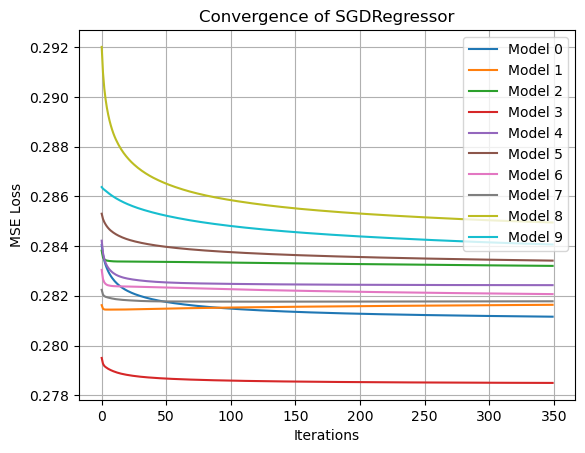

In [36]:

#########################################
#--------SGD Cross validation Training 
#########################################
number_of_models = 10
best_SGD_model_list = []
best_parameters_list = []
val_error_list = []
loss_values_list = []

# Perform cross validation
for i in range(number_of_models):
    print("-----\nModel: ", i)
    x_train, x_val, y_train, y_val = train_test_split(x_seen, y_seen, test_size=0.2, random_state=i)
    best_model,best_params, loss_values = train_and_tune_SGD(x_train, y_train, x_val, y_val)
    print(best_params)
    best_SGD_model_list.append(best_model)
    best_parameters_list.append(best_params)


    # Predict on the validation set with the best model
    y_pred = best_model.predict(x_val)
    
    # Calculate error
    error_val = mean_absolute_error(y_val, y_pred)

    val_error_list.append(error_val)
    loss_values_list.append(loss_values)

val_error = np.mean(np.array(val_error_list))
print('MAE on validation sets: ', val_error)

# Plot the convergence graph
for i, loss_values in enumerate(loss_values_list):
    plt.plot(loss_values, label=f'Model {i}')


file_name = 'convergence_SGD_plot.pdf'

plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Convergence of SGDRegressor')
plt.legend()
plt.grid()

plt.savefig(file_name, format='pdf')
plt.show()



### <font color="orange">  **Tests** </font>

In [37]:
def Calculate_ensemble_MAE(model_list, x_seen, x_unseen, X, y_seen, y_unseen, Y):
    y_seen_pred = []
    y_unseen_pred = []
    Y_pred = []

    for model in model_list:
        y_seen_pred.append(model.predict(x_seen))
    
    for model in model_list:
        y_unseen_pred.append(model.predict(x_unseen))
    
    for model in model_list:
        Y_pred.append(model.predict(X))

    y_seen_pred= np.mean(y_seen_pred,axis=0)
    y_unseen_pred =  np.mean(y_unseen_pred, axis = 0)
    Y_pred = np.mean(Y_pred, axis = 0)

    #Calculates the errors
    MAE_y_seen_pred = np.mean(np.abs(y_seen - np.array(y_seen_pred)))
    MAE_y_unseen_pred = np.mean(np.abs(y_unseen - np.array(y_unseen_pred)))
    MAE_Y = np.mean(np.abs(Y - np.array(Y_pred)))

    return MAE_y_seen_pred, MAE_y_unseen_pred, MAE_Y


#########################################
#--------KNN predictions
#########################################
print("\n--------- KNN Ensemble predictions --------- \n")

MAE_y_seen_pred_KNN, MAE_y_unseen_pred_KNN, MAE_Y_KNN = Calculate_ensemble_MAE(best_KNN_model_list, x_seen, x_unseen, X_scaled, y_seen, y_unseen, Y)

print("MAE in prediction of y_seen: ", MAE_y_seen_pred_KNN)
print("MAE in prediction of y_unseen: ", MAE_y_unseen_pred_KNN)
print("MAE in prediction of Y:", MAE_Y_KNN)


#Prediction on autograder data
y_pred_autograder_KNN = []
y_pred_autograder_SGD = []

for model in best_KNN_model_list:
    y_pred_autograder_KNN.append(model.predict(X_autograder_scaled))

y_pred_autograder_KNN = np.mean(y_pred_autograder_KNN,axis=0)

for model in best_SGD_model_list:
    y_pred_autograder_SGD.append(model.predict(X_autograder_scaled))

y_pred_autograder_SGD = np.mean(y_pred_autograder_SGD,axis=0)


#########################################
#--------SGD predictions
#########################################
print("\n--------- SGD Ensemble predictions --------- \n")

MAE_y_seen_pred_SGD, MAE_y_unseen_pred_SGD, MAE_Y_SGD = Calculate_ensemble_MAE(best_SGD_model_list, x_seen, x_unseen, X_scaled, y_seen, y_unseen, Y)

print("MAE in prediction of y_seen: ", MAE_y_seen_pred_SGD)
print("MAE in prediction of y_unseen: ", MAE_y_unseen_pred_SGD)
print("MAE in prediction of Y:", MAE_Y_SGD)


--------- KNN Ensemble predictions --------- 

MAE in prediction of y_seen:  0.2583643364966497
MAE in prediction of y_unseen:  0.27105237591451214
MAE in prediction of Y: 0.2609019443802222

--------- SGD Ensemble predictions --------- 

MAE in prediction of y_seen:  0.2822957541254966
MAE in prediction of y_unseen:  0.28537788908816686
MAE in prediction of Y: 0.2829121811180306


In [39]:
# # TODO Replace this with your own estimate of the MAE of your best model

estimate_MAE_on_new_data = np.array(MAE_y_unseen_pred_KNN)

# # TODO Replace this with the predictions of your best model

predictions_autograder_data = np.array(y_pred_autograder_KNN)

# # Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_submission.txt", index=False, header=False)